Written by Shashwat Depali Nagar

# Comparing models with different sub-sampled datasets

Analysis done in service of Sharma et al., 2025 (Shared Google Doc linked [here](https://docs.google.com/document/d/1QuqsEp6Gn-UUQTIvXMO4D3E-iXYldk0BOeQnLR4QRDw/edit?tab=t.0))

**Date Started**: January 29, 2025

**Date Last Updated**: February 4, 2025

**Changelog**:
1. January 29, 2025 - First pass
2. February 4, 2025 - Transforming all models to linear models to make R2 directly comparable
3. February 7, 2025 - Meeting with HB. Action iterms defined below:



_Action iterms from Feb 7, 2025 meeting_
1. We are going to proceed with a linear adjusted model with model type.  Units of sample size will not be adjusted. Generate Forest plot of linear model. 
2. What would the predicted value be at 10,000 samples?
3. Perform the same analysis for MSE.


Eventually:
1. Add Neural nets as model type

In [1]:
# Loading libraries
library(dplyr) 
library(readr)
library(tidyr)
library(reshape2)
library(tibble)

library(forestmodel)

library(ggplot2)
library(cowplot)

data_path<-'/nobackup/users/hmbaghda/metastatic_potential/'


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: ggplot2



# Loading data

Current version received on January 24, 2025 (email thread linked [here](https://mail.google.com/mail/u/0/#all/FMfcgzQZSsCzGKBlpQXdPWsbHKjlsNGb))

In [2]:
res <- read_csv(file.path(data_path, "processed", "power_analysis_transcriptomics.csv")) %>%
  select(-1)
y_joint = read_csv(file.path(data_path, 'processed',  'metastatic_potential_joint.csv')) %>%
select(-1) 
y_proteomics = read_csv(file.path(data_path, 'processed',  'metastatic_potential_protein.csv')) %>%
select(-1) 
res <- res %>%
  filter(!(train_sample_size %in% c(nrow(y_joint), nrow(y_proteomics))))

New names:
• `` -> `...1`
Rows: 29030 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): model
dbl (7): ...1, fold, train_sample_size, train_corr, test_corr, train_mse, te...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 247 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (4): CI.05, CI.95, mean, penetrance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 248 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (4): CI.05, CI.95, mean, penetrance

ℹ Use `spec()` to retrieve the full column specificatio

In [3]:
res_ann<-read_csv(file.path(data_path, "processed", "power_analysis_ann_transcriptomics.csv"))
res_ann<-res_ann[res_ann$set == 'test',]
names(res_ann)<-c('fold', 'iteration', 'train_sample_size', 'set', 'test_corr', 'test_mse')
res_ann <- res_ann %>% select(-iteration, -set)
res_ann$train_sample_size<-as.integer(gsub("^[^0-9]+", "", res_ann$train_sample_size))
res_ann$model<-'ANN'

col_names<-c('model', 'fold', 'train_sample_size', 'test_corr', 'test_mse')
res<-rbind(res[col_names], res_ann[col_names])

res$model <- factor(res$model, levels = c("svr_linear", "svr_rbf", "svr_poly", "ANN"))

Rows: 18020 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): iteration, subset, set
dbl (3): fold, r, MSE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
df<-res

Based on Supplementary Figure _X_ (numbered _CC_ at time of writing), the variables of interest are:
1. Pearson Correlation
2. MSE

**Assumption**: Proceeding with the `test` version of each variable here.

1. Pearson Correlation --> `test_corr`
2. MSE --> `test_mse`

In [5]:
df %>%
count(model)

model,n
<fct>,<int>
svr_linear,9010
svr_rbf,9010
svr_poly,9010
ANN,9010


## 1. Linear Modeling

In [6]:
linearSVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    )
)


summary(linearSVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_linear"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52073 -0.06787  0.00291  0.07359  0.32571 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.085e-01  2.349e-03  131.35   <2e-16 ***
train_sample_size 4.589e-04  9.630e-06   47.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1024 on 9008 degrees of freedom
Multiple R-squared:  0.2014,	Adjusted R-squared:  0.2013 
F-statistic:  2271 on 1 and 9008 DF,  p-value: < 2.2e-16


In [7]:
polySVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    )
)


summary(polySVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_poly"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53566 -0.06787  0.00813  0.07259  0.31524 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.047e-01  2.317e-03  131.47   <2e-16 ***
train_sample_size 5.364e-04  9.501e-06   56.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.101 on 9008 degrees of freedom
Multiple R-squared:  0.2613,	Adjusted R-squared:  0.2612 
F-statistic:  3187 on 1 and 9008 DF,  p-value: < 2.2e-16


In [8]:
rbfSVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    )
)


summary(rbfSVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_rbf"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56084 -0.08253  0.02656  0.08379  0.29564 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.3012577  0.0026109  115.39   <2e-16 ***
train_sample_size 0.0005437  0.0000107   50.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1138 on 9008 degrees of freedom
Multiple R-squared:  0.2226,	Adjusted R-squared:  0.2225 
F-statistic:  2580 on 1 and 9008 DF,  p-value: < 2.2e-16


In [9]:
ann_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "ANN"
    )
)


summary(ann_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "ANN"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48665 -0.07857  0.00877  0.08804  0.33860 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.2730853  0.0027799   98.24   <2e-16 ***
train_sample_size 0.0004809  0.0000114   42.19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1211 on 9008 degrees of freedom
Multiple R-squared:  0.165,	Adjusted R-squared:  0.1649 
F-statistic:  1780 on 1 and 9008 DF,  p-value: < 2.2e-16


## 2. Power Modeling

$$
    Correlation = a * {train sample size}^b
$$

To linearlize this, we can transform the data:
$$
    log_{10}(Correlation) = log_{10}(a) + b *log_{10}(train sample size)
$$



____ 


With Model Type

To linearlize this, we can transform the data:
$$
    log_{10}(Correlation) = log_{10}(a) + b *log_{10}(train sample size) + c * Model Type
$$



$$
    Y = Intercept + b *log_{10}(train sample size) + c * Model Type
$$

In [10]:
linearSVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(linearSVR_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_linear") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.04049 -0.06341  0.01546  0.08523  0.39147 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.009997   0.011640  -86.77   <2e-16 ***
log10_train_sample_size  0.265751   0.005115   51.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1421 on 8973 degrees of freedom
  (35 observations deleted due to missingness)
Multiple R-squared:  0.2313,	Adjusted R-squared:  0.2312 
F-statistic:  2700 on 1 and 8973 DF,  p-value: < 2.2e-16


In [11]:
polySVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(polySVR_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_poly") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.07028 -0.06094  0.02022  0.08013  0.36996 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.054443   0.011517  -91.56   <2e-16 ***
log10_train_sample_size  0.291118   0.005062   57.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1408 on 8980 degrees of freedom
  (28 observations deleted due to missingness)
Multiple R-squared:  0.2692,	Adjusted R-squared:  0.2691 
F-statistic:  3308 on 1 and 8980 DF,  p-value: < 2.2e-16


In [12]:
rbfSVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(rbfSVR_power_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_rbf") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.73305 -0.07204  0.04303  0.09385  0.37490 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.075981   0.013065  -82.36   <2e-16 ***
log10_train_sample_size  0.297524   0.005742   51.82   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1597 on 8978 degrees of freedom
  (30 observations deleted due to missingness)
Multiple R-squared:  0.2302,	Adjusted R-squared:  0.2301 
F-statistic:  2685 on 1 and 8978 DF,  p-value: < 2.2e-16


In [13]:
ann_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "ANN"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(ann_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "ANN") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.40949 -0.07183  0.03455  0.11592  0.42095 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.106964   0.015815  -69.99   <2e-16 ***
log10_train_sample_size  0.288506   0.006944   41.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1917 on 8934 degrees of freedom
  (74 observations deleted due to missingness)
Multiple R-squared:  0.1619,	Adjusted R-squared:  0.1618 
F-statistic:  1726 on 1 and 8934 DF,  p-value: < 2.2e-16


## 3. Exponential Modeling

Correlation = a * e<sup>train_sample_size * b</sup>



$$
    Correlation = a * e^{b * {train sample size}}
$$

To linearlize this, we can transform the data:
$$
    log_{e}(Correlation) = log_{e}(a) + b * (train sample size)
$$

In [14]:
linearSVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(linearSVR_exp_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_linear") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.09734 -0.06411  0.01810  0.08979  0.33462 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.459e-01  3.379e-03 -161.56   <2e-16 ***
train_sample_size  6.240e-04  1.383e-05   45.13   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1463 on 8973 degrees of freedom
  (35 observations deleted due to missingness)
Multiple R-squared:  0.185,	Adjusted R-squared:  0.1849 
F-statistic:  2036 on 1 and 8973 DF,  p-value: < 2.2e-16


In [15]:
polySVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(polySVR_exp_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_poly") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.13030 -0.06135  0.02113  0.08636  0.31211 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.488e-01  3.349e-03 -163.89   <2e-16 ***
train_sample_size  6.963e-04  1.371e-05   50.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1452 on 8980 degrees of freedom
  (28 observations deleted due to missingness)
Multiple R-squared:  0.2232,	Adjusted R-squared:  0.2231 
F-statistic:  2580 on 1 and 8980 DF,  p-value: < 2.2e-16


In [16]:
rbfSVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(rbfSVR_exp_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_rbf") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.71591 -0.07455  0.03812  0.10281  0.31356 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.592e-01  3.779e-03    -148   <2e-16 ***
train_sample_size  7.116e-04  1.547e-05      46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1638 on 8978 degrees of freedom
  (30 observations deleted due to missingness)
Multiple R-squared:  0.1908,	Adjusted R-squared:  0.1907 
F-statistic:  2116 on 1 and 8978 DF,  p-value: < 2.2e-16


In [17]:
ann_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "ANN"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(ann_exp_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "ANN") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.41006 -0.07208  0.03591  0.11857  0.36282 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -6.076e-01  4.516e-03 -134.56   <2e-16 ***
train_sample_size  6.987e-04  1.844e-05   37.88   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1944 on 8934 degrees of freedom
  (74 observations deleted due to missingness)
Multiple R-squared:  0.1384,	Adjusted R-squared:  0.1383 
F-statistic:  1435 on 1 and 8934 DF,  p-value: < 2.2e-16


## Calculating Performance Metrics

In [18]:
# Function to calculate performance metrics
calc_metrics <- function(model, data, ground_truth, log_transformed = FALSE) {
    
  predicted_vals <- predict(model, newdata = data)
    
  # If the model was fit in log-space, exponentiate predictions
  if (log_transformed) {
    predicted_vals <- exp(predicted_vals)
  }
  
  mse <- mean((predicted_vals - ground_truth)^2)
  rmse <- sqrt(mse)
  
  return(c(MSE = mse, RMSE = rmse))
}


In [19]:
input_models <- c("svr_linear", "svr_poly", "svr_rbf", 'ANN') # the variable names here are a little confusing
model_types <- c("linear", "power", "exp") # the variable names here are a little confusing
power_models_out = list()
flag <- 0 # Setting Sentinel

for (curr_input in input_models) {
    curr_df <- df %>%
    filter(
        model == curr_input
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size),
        log10_test_mse = log10(test_mse),
        fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr)),
        log10_fisherZ_test_corr = log10(fisherZ_test_corr)
    )

    curr_r2_linear_model <- lm(
        fisherZ_test_corr ~ train_sample_size,
        data = curr_df
    )

    curr_r2_power_model <- lm(
        log10_fisherZ_test_corr ~ log10_train_sample_size,
        data = curr_df
    )
    
    curr_r2_exp_model <- lm(
        log10_fisherZ_test_corr ~ train_sample_size,
        data = curr_df
    )
    
    curr_mse_linear_model <- lm(
        test_mse ~ train_sample_size,
        data = curr_df
    )

    curr_mse_power_model <- lm(
        log10_test_mse ~ log10_train_sample_size,
        data = curr_df
    )
    
    curr_mse_exp_model <- lm(
        log10_test_mse ~ train_sample_size,
        data = curr_df
    )
    
    power_models_out[[curr_input]] = list('corr' = curr_r2_power_model, 
                                         'mse' = curr_mse_power_model)
    
    for (curr_model in model_types) {
        curr_r2_stat_model <- get(paste0("curr_r2_", curr_model, "_model"))
        
        curr_mse_stat_model <- get(paste0("curr_mse_", curr_model, "_model"))
        
        # Below, I'm calculating a lot of different linear model performance
        # metrics - but only 1 will be used for the final comparison.
        
        if (curr_model %in% c("power", "exp")) {
            curr_metrics_r2 <- calc_metrics(curr_r2_stat_model, curr_df, curr_df$test_corr, log_transformed = T) %>%
            t() %>%
            data.frame
        } else {
            curr_metrics_r2 <- calc_metrics(curr_r2_stat_model, curr_df, curr_df$test_corr) %>%
            t() %>%
            data.frame
        }
        
        curr_metrics_r2$R2 <- summary(curr_r2_stat_model)$r.squared
        curr_metrics_r2$R2_adj <- summary(curr_r2_stat_model)$adj.r.squared
        curr_metrics_r2$AIC <- AIC(curr_r2_stat_model)
        curr_metrics_r2$BIC <- BIC(curr_r2_stat_model)
        curr_metrics_r2$Input <- curr_input
        curr_metrics_r2$Model <- curr_model
        curr_metrics_r2$TargetVariable <- "R2"
        
        # Adding metrics for MSE
        
        if (curr_model %in% c("power", "exp")) {
            curr_metrics_mse <- calc_metrics(curr_mse_stat_model, curr_df, curr_df$test_corr, log_transformed = T) %>%
            t() %>%
            data.frame
        } else {
            curr_metrics_mse <- calc_metrics(curr_mse_stat_model, curr_df, curr_df$test_corr) %>%
            t() %>%
            data.frame
        }
        
        curr_metrics_mse$R2 <- summary(curr_mse_stat_model)$r.squared
        curr_metrics_mse$R2_adj <- summary(curr_mse_stat_model)$adj.r.squared
        curr_metrics_mse$AIC <- AIC(curr_mse_stat_model)
        curr_metrics_mse$BIC <- BIC(curr_mse_stat_model)
        curr_metrics_mse$Input <- curr_input
        curr_metrics_mse$Model <- curr_model
        curr_metrics_mse$TargetVariable <- "MSE"

        if (flag == 0) {
            final_df <- rbind(curr_metrics_r2, curr_metrics_mse)
            flag <- 1 # Changing Sentinel
        } else {
            final_df <- rbind(final_df, curr_metrics_r2, curr_metrics_mse)
        }
    }
}

# final_df %>%
# write_delim(file.path(data_path, 'processed', 'poweranalysis_individual_lms.txt')
#             delim = '\t')

final_df %>%
arrange(
    desc(R2_adj)
)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


MSE,RMSE,R2,R2_adj,AIC,BIC,Input,Model,TargetVariable
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1.26728365,1.1257369,0.28520843,0.28512908,-18189.587,-18168.269,ANN,power,MSE
0.08525163,0.2919788,0.27454177,0.27446098,-8403.851,-8382.542,svr_poly,power,R2
0.01160916,0.1077458,0.25761803,0.25753562,-12442.860,-12421.542,svr_poly,linear,R2
0.08652701,0.2941547,0.23537106,0.23528590,-6132.605,-6111.296,svr_rbf,power,R2
4.91816955,2.2176946,0.23316032,0.23307519,15360.679,15381.997,ANN,linear,MSE
0.08672211,0.2944862,0.23290396,0.23281847,-8240.742,-8219.436,svr_linear,power,R2
0.08565405,0.2926671,0.23017830,0.23009258,-7870.720,-7849.411,svr_poly,exp,R2
0.01446023,0.1202507,0.22412430,0.22403817,-10385.407,-10364.089,svr_rbf,linear,R2
1.26230868,1.1235251,0.21974950,0.21966289,-17400.095,-17378.777,ANN,exp,MSE


In [20]:
final_df$TargetVariable[final_df$TargetVariable == 'R2'] = 'Pearson'
names(final_df)[names(final_df) == "TargetVariable"] <- "Performance.Metric"
final_df <- final_df[order(final_df$Performance.Metric, final_df$Input, final_df$Model), ]
# final_df<-final_df[c('R2_adj', 'AIC', 'BIC', 'Input', 'Model', 'Performance.Metric')]
write.csv(final_df, 
         file.path(data_path, 'processed', 'TableVV.csv'))

In [21]:
aggregate(R2_adj ~ Model + Performance.Metric, data = final_df, FUN = mean) %>% 
arrange(
    desc(Performance.Metric),
    desc(R2_adj)
)


Model,Performance.Metric,R2_adj
<chr>,<chr>,<dbl>
power,Pearson,0.2267345
linear,Pearson,0.2091604
exp,Pearson,0.1891727
power,MSE,0.1389638
linear,MSE,0.1251313
exp,MSE,0.1160433


In [22]:
aggregate(AIC ~ Model + Performance.Metric, data = final_df, FUN = mean)%>% 
arrange(
    desc(Performance.Metric),
    AIC
)

Model,Performance.Metric,AIC
<chr>,<chr>,<dbl>
linear,Pearson,-11187.374
power,Pearson,-6473.167
exp,Pearson,-6042.760
power,MSE,-19179.637
exp,MSE,-18917.714
linear,MSE,11500.785


In [23]:
aggregate(BIC ~ Model + Performance.Metric, data = final_df, FUN = mean)%>% 
arrange(
    desc(Performance.Metric),
    BIC
)

Model,Performance.Metric,BIC
<chr>,<chr>,<dbl>
linear,Pearson,-11166.055
power,Pearson,-6451.863
exp,Pearson,-6021.456
power,MSE,-19158.319
exp,MSE,-18896.395
linear,MSE,11522.103


In [24]:
aggregate(MSE ~ Model + Performance.Metric, data = final_df, FUN = mean)%>% 
arrange(
    desc(Performance.Metric),
    MSE
)

Model,Performance.Metric,MSE
<chr>,<chr>,<dbl>
linear,Pearson,0.01330222
power,Pearson,0.08716735
exp,Pearson,0.08755520
exp,MSE,1.07691808
power,MSE,1.07877138
linear,MSE,3.81901548


We proceed with power models, as they have the best performance for adjusted R^2, as well as for AIC/BIC for MSE. 

Visualize:

In [25]:
res_nonn <- read_csv(file.path(data_path, "processed", "power_analysis_transcriptomics.csv")) %>%
  select(-1)


New names:
• `` -> `...1`
Rows: 29030 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): model
dbl (7): ...1, fold, train_sample_size, train_corr, test_corr, train_mse, te...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [26]:
mean_value <- res_nonn %>%
  filter(train_sample_size == 433) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4893424


In [27]:
mean_value <- res_nonn %>%
  filter(train_sample_size == 260) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4549419


In [28]:
mean_value <- res_nonn %>%
  filter(train_sample_size == 216) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4324327


In [29]:
mean_value <- res_nonn %>%
  filter(train_sample_size == dim(y_proteomics)[1]) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4374775


In [30]:
mean_value <- res_nonn %>%
  filter(train_sample_size == dim(y_joint)[1]) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4369364


In [31]:
get_power_curve<-function(power_model, performance.metric, model){
    a = 10^power_model$coefficients[['(Intercept)']]
    b = power_model$coefficients[['log10_train_sample_size']]
    x <- seq(1, max(res$train_sample_size), length.out = 5000)  # Generate x values
    
#     actual_samples<-sapply(seq(0, max(res$train_sample_size), length=11)[2:11], function(x) round(x))
#     x<-sort(union(x, actual_samples))                       
                           
                           
    plot_df <- data.frame(train_sample_size = x, value = a * x^b)
    plot_df[['performance.metric']]<-performance.metric
    plot_df[['model']]<-model
    plot_df[['label']]<-sprintf("y = %.2fx^%.2f", a,b)
    
    plot_df
    
    return(plot_df)
}

gpc_metric_map = list('corr' = 'test_corr', 'mse' = 'test_mse')
gpc_model_map = list('svr_linear' = 'Linear SVR', 'svr_poly' = 'Polynomial SVR', 'svr_rbf' = 'RBF SVR', 
                    'ANN' = 'Single NN')

counter<-1
power_plots = list()
for (mt in names(power_models_out)){
    for (metric in c('corr', 'mse')){
        power_plots[[counter]]= get_power_curve(power_models_out[[mt]][[metric]], 
                                                performance.metric = gpc_metric_map[[metric]], 
                                                model = gpc_model_map[[mt]])
        counter<-counter + 1
    }
}
power_plots<-do.call(rbind, power_plots)

In [32]:
viz.df <- res %>% select(-fold)

# apply fisher Z transformation
viz.df<-viz.df %>%
group_by(model) %>%
mutate(fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr))) %>%
select(-test_corr) %>% rename(test_corr = fisherZ_test_corr)

# continue formatting
viz.df<-melt(viz.df, id.vars=c('train_sample_size', 'model'), value.name = 'value', 
    variable.name = 'performance.metric')

title_map <- c("svr_linear" = "Linear SVR", 
               "svr_rbf" = "RBF SVR", 
               "svr_poly" = "Polynomial SVR", 
              'ANN' = 'Single NN')

viz.df <- viz.df %>%
  mutate(model_title = factor(model, levels = names(title_map), labels = title_map)) %>%
select(-model) %>% rename(model = model_title)

power_plots_label = power_plots
power_plots<-power_plots[names(viz.df)]

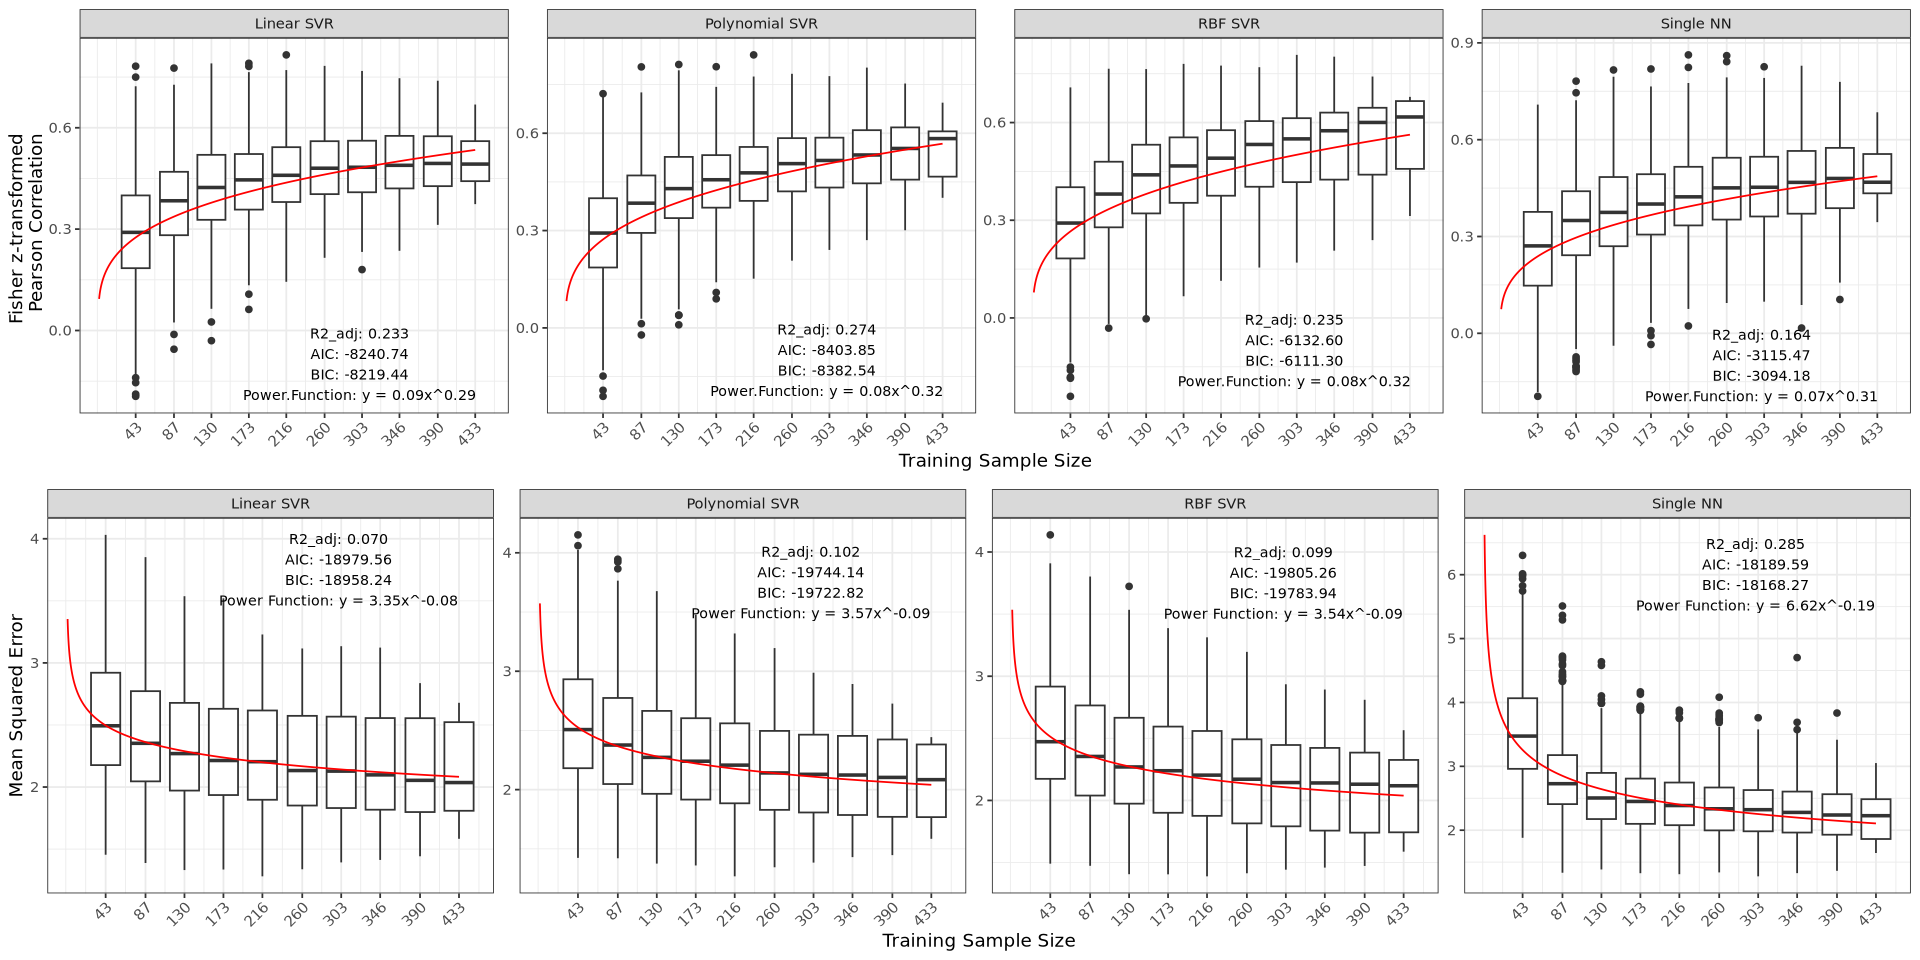

In [33]:
h = 8
w = 16

options(repr.plot.width = w, repr.plot.height = h)

model_map <- c("linearSVR" = "Linear SVR", 
               "rbfSVR" = "RBF SVR", 
               "polySVR" = "Polynomial SVR")

annotation_df<-final_df[(final_df$Model == 'power') & (final_df$Performance.Metric == 'Pearson'), ]
annotation_df =  annotation_df %>% select(-Model) %>%
mutate(model = factor(Input, levels = names(title_map), labels = title_map))

annotation_df['Power.Function']<-power_plots_label[power_plots_label$performance.metric == 'test_corr',] %>%
distinct(model, label) %>%
arrange(match(model, annotation_df$model)) %>%
select(label)

annotation_df<-annotation_df%>%
mutate(label = sprintf("R2_adj: %.3f\nAIC: %.2f\nBIC: %.2f\nPower.Function: %s", R2_adj, AIC, BIC,Power.Function)) %>%
select(model, label)
annotation_df[['x']] = 300
annotation_df[['y']] = -0.1

g1 <- ggplot() +
  geom_boxplot(data = viz.df[viz.df$performance.metric == 'test_corr',], 
               aes(x = as.numeric(train_sample_size), y = value, group = train_sample_size))+
  geom_line(data = power_plots[power_plots$performance.metric == 'test_corr',], 
            aes(x = as.numeric(train_sample_size), y = value), color = 'red') + 
# facet_grid(~model, scales = "free_y") + 
 facet_wrap(~model, ncol = 4, scales = "free_y")+
geom_text(data = annotation_df, aes(x = x, y = y, label = label), inherit.aes = T, size = 3) +
labs(x = "Training Sample Size", y = "Fisher z-transformed \n Pearson Correlation") +
theme_bw() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_x_continuous(breaks = sapply(seq(0, max(res$train_sample_size), length=11)[2:11], function(x) round(x)))

# MSE
annotation_df<-final_df[(final_df$Model == 'power') & (final_df$Performance.Metric == 'MSE'), ]
annotation_df =  annotation_df %>% select(-Model) %>%
mutate(model = factor(Input, levels = names(title_map), labels = title_map))

annotation_df['Power.Function']<-power_plots_label[power_plots_label$performance.metric == 'test_mse',] %>%
distinct(model, label) %>%
arrange(match(model, annotation_df$model)) %>%
select(label)

annotation_df<-annotation_df%>%
mutate(label = sprintf("R2_adj: %.3f\nAIC: %.2f\nBIC: %.2f\nPower Function: %s", R2_adj, AIC, BIC,Power.Function)) %>%
select(model, label)
annotation_df[['x']] = 300
annotation_df[['y']] = 3.75
annotation_df[1, c('x', 'y')] = c(300, 6)

g2 <- ggplot() +
  geom_boxplot(data = viz.df[viz.df$performance.metric == 'test_mse',], 
               aes(x = as.numeric(train_sample_size), y = value, group = train_sample_size))+
  geom_line(data = power_plots[power_plots$performance.metric == 'test_mse',], 
            aes(x = as.numeric(train_sample_size), y = value), color = 'red') + 
# facet_grid(~model, scales = "free_y") + 
facet_wrap(~model, ncol = 4, scales = "free_y")+
geom_text(data = annotation_df, aes(x = x, y = y, label = label), inherit.aes = T, size = 3) +
labs(x = "Training Sample Size", y = "Mean Squared Error") +
theme_bw() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_x_continuous(breaks = sapply(seq(0, max(res$train_sample_size), length=11)[2:11], function(x) round(x)))

g<-plot_grid(g1, g2, ncol = 1)
                                   
ggsave(filename = file.path(data_path, "figures", "power_analysis_barplots.png"), 
       plot = g, dpi = 300, width = w, height = h)
                           
g


## Multivariable modeling to understand which model type works the best

In [34]:
curr_df <- df %>%
mutate(
    log10_test_corr = log10(test_corr),
    log10_train_sample_size = log10(train_sample_size),
    log10_test_mse = log10(test_mse),
    
    # This transformation enables a bounded variable (r is bounded by [-1,1]) to be treated as a continuous variable
    fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr)),
    log10_fisherZ_test_corr = log10(fisherZ_test_corr)
)

multi_R2_model <- lm(
    log10_fisherZ_test_corr ~ log10_train_sample_size + model,
    data = curr_df
)

summary(multi_R2_model)

calc_metrics(multi_R2_model, curr_df, df$test_corr, log_transformed = F)

# forest_model(multi_R2_model)

# ggsave('Output/MultivariableR2Model.pdf', useDingbats = F, units = 'in', h = 6, w = 8)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”



Call:
lm(formula = log10_fisherZ_test_corr ~ log10_train_sample_size + 
    model, data = curr_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.42867 -0.07813  0.02724  0.10440  0.47347 

Coefficients:
                         Estimate Std. Error  t value Pr(>|t|)    
(Intercept)             -1.079937   0.007189 -150.215  < 2e-16 ***
log10_train_sample_size  0.309619   0.003083  100.412  < 2e-16 ***
modelsvr_rbf             0.008137   0.002555    3.185  0.00145 ** 
modelsvr_poly            0.014843   0.002555    5.810  6.3e-09 ***
modelANN                -0.048791   0.002558  -19.075  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1712 on 35868 degrees of freedom
  (167 observations deleted due to missingness)
Multiple R-squared:  0.2319,	Adjusted R-squared:  0.2318 
F-statistic:  2707 on 4 and 35868 DF,  p-value: < 2.2e-16


MSE      RMSE 
0.6441544 0.8025923

In [49]:
# curr_df <- df %>%
# mutate(
#     log10_test_corr = log10(test_corr),
#     log10_train_sample_size = log10(train_sample_size),
#     log10_test_mse = log10(test_mse),
    
#     # This transformation enables a bounded variable (r is bounded by [-1,1]) to be treated as a continuous variable
#     fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr)),
#     log10_fisherZ_test_corr = log10(fisherZ_test_corr)
# )

# multi_R2_linear_model <- lm(
#     fisherZ_test_corr ~ train_sample_size + model,
#     data = curr_df
# )

# summary(multi_R2_linear_model)

# calc_metrics(multi_R2_linear_model, curr_df, df$test_corr, log_transformed = F)

# forest_model(multi_R2_linear_model)

# # ggsave('Output/MultivariableR2Model.pdf', useDingbats = F, units = 'in', h = 6, w = 8)

In [35]:
curr_df <- df %>%
mutate(
    log10_test_corr = log10(test_corr),
    log10_train_sample_size = log10(train_sample_size),
    log10_test_mse = log10(test_mse)
)
multi_mse_model <- lm(
    log10_test_mse ~ log10_train_sample_size + model,
    data = curr_df
)

summary(multi_mse_model)

calc_metrics(multi_mse_model, curr_df, df$test_corr, log_transformed = T)

# forest_model(multi_mse_model)

# ggsave('Output/MultivariableMSEModel.pdf', useDingbats = F, units = 'in', h = 6, w = 8)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_mse ~ log10_train_sample_size + model, 
    data = curr_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30594 -0.06477  0.00157  0.07006  0.33407 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.602256   0.003519 171.151  < 2e-16 ***
log10_train_sample_size -0.112534   0.001510 -74.526  < 2e-16 ***
modelsvr_rbf            -0.004577   0.001260  -3.632 0.000281 ***
modelsvr_poly           -0.003490   0.001260  -2.770 0.005614 ** 
modelANN                 0.047046   0.001260  37.336  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08458 on 36035 degrees of freedom
Multiple R-squared:  0.1799,	Adjusted R-squared:  0.1798 
F-statistic:  1976 on 4 and 36035 DF,  p-value: < 2.2e-16


MSE     RMSE 
1.077913 1.038226

Visualize:

In [36]:
viz.df<-summary(multi_R2_model)$coefficients
rownames(viz.df)<-c('Intercept', 'log10(Train Sample Size)', 'Polynomial SVR', 'RBF SVR', 'Single NN')
viz.df<-as.data.frame(viz.df) %>% tibble::rownames_to_column("term")

# g1<-ggplot(viz.df, aes(x = term, y = Estimate)) +
#   geom_point() + 
#   geom_errorbar(aes(ymin = Estimate - `Std. Error`, ymax = Estimate + `Std. Error`), width = 0.2) +
#   theme_bw() +
#   labs(x = "Predictor", y = "Estimate", title = 'Fisher z-transformed Pearson Correlation')+
# theme(plot.title = element_text(hjust = 0.5))

In [58]:
viz.df<-summary(multi_R2_model)$coefficients
rownames(viz.df)<-c('Intercept', 'log10(Train Sample Size)', 'Polynomial SVR', 'RBF SVR', 'Single NN')
viz.df<-as.data.frame(viz.df) %>% tibble::rownames_to_column("term")

g1<-ggplot(viz.df, aes(x = term, y = Estimate)) +
  geom_point() + 
  geom_errorbar(aes(ymin = Estimate - `Std. Error`, ymax = Estimate + `Std. Error`), width = 0.2) +
  theme_bw() +
  labs(x = "Predictor", y = "Estimate", title = 'Fisher z-transformed Pearson Correlation')+
theme(plot.title = element_text(hjust = 0.5), 
     axis.text.x = element_text(angle = 45, hjust = 1))


# plot the predictions
inverse_fisher_z <- function(z) {
  return((exp(2 * z) - 1) / (exp(2 * z) + 1))
}


predicted.data <- expand.grid(
  train_sample_size = seq(1, 1e4, length.out = 1e4), 
  model = c("svr_linear", "svr_poly", "svr_rbf", 'ANN')     
) %>%
  mutate(log10_train_sample_size = log10(train_sample_size))

predicted.data$log10_fisherZ_test_corr <- predict(multi_R2_model, newdata = predicted.data)
predicted.data$fisherZ_test_corr<-10^predicted.data$log10_fisherZ_test_corr
predicted.data$test_corr<-inverse_fisher_z(predicted.data$fisherZ_test_corr)

title_map <- c("svr_linear" = "Linear SVR", 
               "svr_rbf" = "RBF SVR", 
               "svr_poly" = "Polynomial SVR", 
              'ANN' = 'Single NN')

predicted.data <- predicted.data %>%
  mutate(model_title = factor(model, levels = names(title_map), labels = title_map)) %>%
select(-model) %>% rename(model = model_title)

predicted.data.corr<-predicted.data


pf<-summary(multi_R2_model)$coefficients
a=10^pf['(Intercept)', 'Estimate']
b = pf['log10_train_sample_size', 'Estimate']

m="model"
i = 'i'
m_i <- sprintf("%s[%s]", m, i)
equation = parse(text = sprintf("z == %.2f ~ N^%.2f ~ '×' ~ 10^%s", a, b, m_i))

m <- "model"
i <- "polynomial_svr"
m_i_value <- pf['modelsvr_poly','Estimate'] 
poly_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

m <- "model"
i <- "rbf_svr"
m_i_value <- pf['modelsvr_rbf','Estimate'] 
rbf_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

m <- "model"
i <- "ANN"
m_i_value <- pf['modelANN','Estimate'] 
ann_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

viz.df.main<-predicted.data
names(viz.df.main)[names(viz.df.main) == "model"] <- "Model"
g2_main<-ggplot(viz.df.main, aes(x = train_sample_size, y = test_corr, 
                               color = Model)) +
  geom_line(linewidth = 0.75) + 
  theme_bw() +
  labs(x = "Train Sample Size", y = "Pearson Correlation", title = 'Predicted Performance by Model Type')+
theme(plot.title = element_text(hjust = 0.5)) + 
theme(
  plot.title = element_text(size = rel(1.5)),
  axis.title = element_text(size = rel(1.5)),
  axis.text = element_text(size = rel(1.5)),
  legend.title = element_text(size = rel(1.5)),
  legend.text = element_text(size = rel(1.5))
)

g2<-g2_main+
annotate('text', x = 7500, y = 0.4, label = equation, 
         size = 3, fontface = "bold") + 
annotate('text', x = 7500, y = 0.3, label = poly_m_i, 
         size = 3, fontface = "bold")+
annotate('text', x = 7500, y = 0.2, label = rbf_m_i, 
         size = 3, fontface = "bold")+
annotate('text', x = 7500, y = 0.1, label = ann_m_i, 
         size = 3, fontface = "bold")

# g<-plot_grid(g1, g2, ncol = 2)
# g                 
# ggsave(filename = file.path(data_path, "figures", "corr_power_analysis_model_fit.png"), 
#        plot = g, dpi = 300, width = w, height = h)


In [38]:
h = 4
w = 12

options(repr.plot.width = w, repr.plot.height = h)

viz.df<-summary(multi_mse_model)$coefficients
rownames(viz.df)<-c('Intercept', 'log10(Train Sample Size)', 'Polynomial SVR', 'RBF SVR', 'Single NN')
viz.df<-as.data.frame(viz.df) %>% tibble::rownames_to_column("term")

g1B<-ggplot(viz.df, aes(x = term, y = Estimate)) +
  geom_point() + 
  geom_errorbar(aes(ymin = Estimate - `Std. Error`, ymax = Estimate + `Std. Error`), width = 0.2) +
  theme_bw() +
  labs(x = "Predictor", y = "Estimate", title = 'Mean Squared Error')+
theme(plot.title = element_text(hjust = 0.5), 
     axis.text.x = element_text(angle = 45, hjust = 1))


predicted.data <- expand.grid(
  train_sample_size = seq(1, 1e4, length.out = 1e4), 
  model = c("svr_linear", "svr_poly", "svr_rbf", 'ANN')     
) %>%
  mutate(log10_train_sample_size = log10(train_sample_size))

predicted.data$log10_mse <- predict(multi_mse_model, newdata = predicted.data)
predicted.data$test_mse<-10^predicted.data$log10_mse

title_map <- c("svr_linear" = "Linear SVR", 
               "svr_rbf" = "RBF SVR", 
               "svr_poly" = "Polynomial SVR", 
              'ANN' = 'Single NN')

predicted.data <- predicted.data %>%
  mutate(model_title = factor(model, levels = names(title_map), labels = title_map)) %>%
select(-model) %>% rename(model = model_title)


pf<-summary(multi_mse_model)$coefficients
a=10^pf['(Intercept)', 'Estimate']
b = pf['log10_train_sample_size', 'Estimate']

m="model"
i = 'i'
m_i <- sprintf("%s[%s]", m, i)
equation = parse(text = sprintf("MSE == %.2f ~ N^%.2f ~ '×' ~ 10^%s", a, b, m_i))

m <- "model"
i <- "polynomial_svr"
m_i_value <- pf['modelsvr_poly','Estimate'] 
poly_m_i <- parse(text = sprintf("%s[%s] == %.3f", m, i, m_i_value))

m <- "model"
i <- "rbf_svr"
m_i_value <- pf['modelsvr_rbf','Estimate'] 
rbf_m_i <- parse(text = sprintf("%s[%s] == %.3f", m, i, m_i_value))

m <- "model"
i <- "ANN"
m_i_value <- pf['modelANN','Estimate'] 
ann_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

g2B<-ggplot(predicted.data, aes(x = train_sample_size, y = test_mse, 
                               color = model)) +
  geom_line() + 
  theme_bw() +
  labs(x = "Train Sample Size", y = "Mean Squared Error", title = 'Predicted Performance by Model Type')+
theme(plot.title = element_text(hjust = 0.5))+
annotate('text', x = 7500, y = 3, label = equation, 
         size = 3, fontface = "bold") + 
annotate('text', x = 7500, y = 2.75, label = poly_m_i, 
         size = 3, fontface = "bold")+
annotate('text', x = 7500, y = 2.5, label = rbf_m_i, 
         size = 3, fontface = "bold")+
annotate('text', x = 7500, y = 2.25, label = ann_m_i, 
         size = 3, fontface = "bold")

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


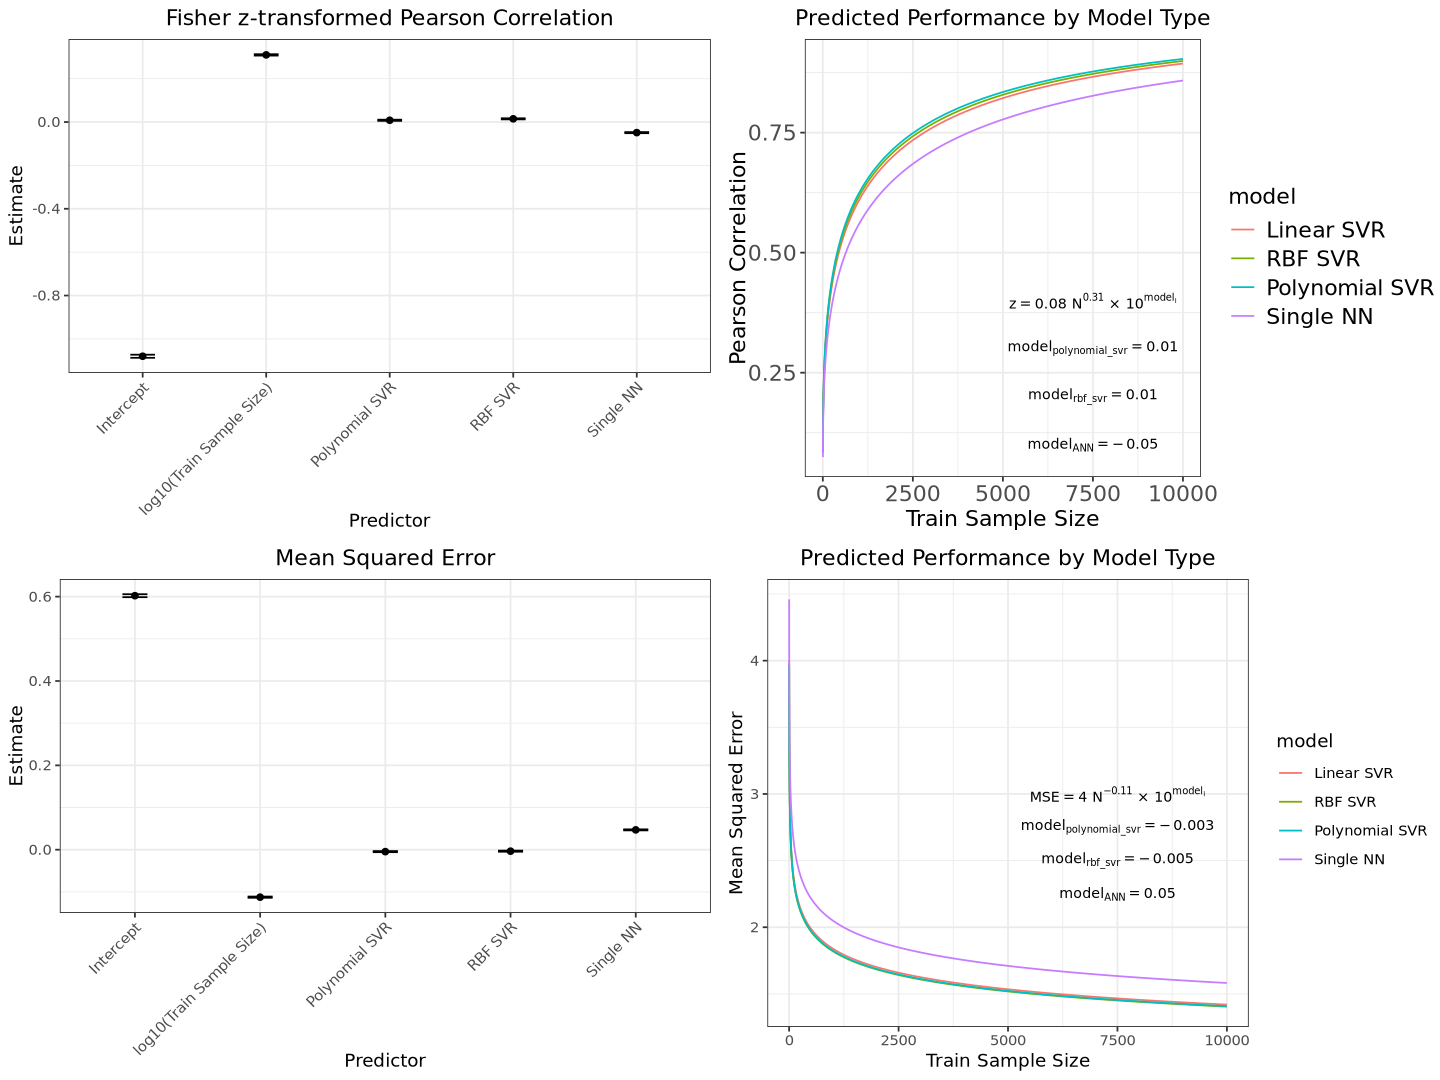

In [41]:
h = 9
w = 12

options(repr.plot.width = w, repr.plot.height = h)
g<-plot_grid(g1, g2, g1B, g2B, ncol = 2)

g                 
ggsave(filename = file.path(data_path, "figures", "power_analysis_model_fits_all.png"), 
       plot = g, dpi = 300, width = w, height = h)


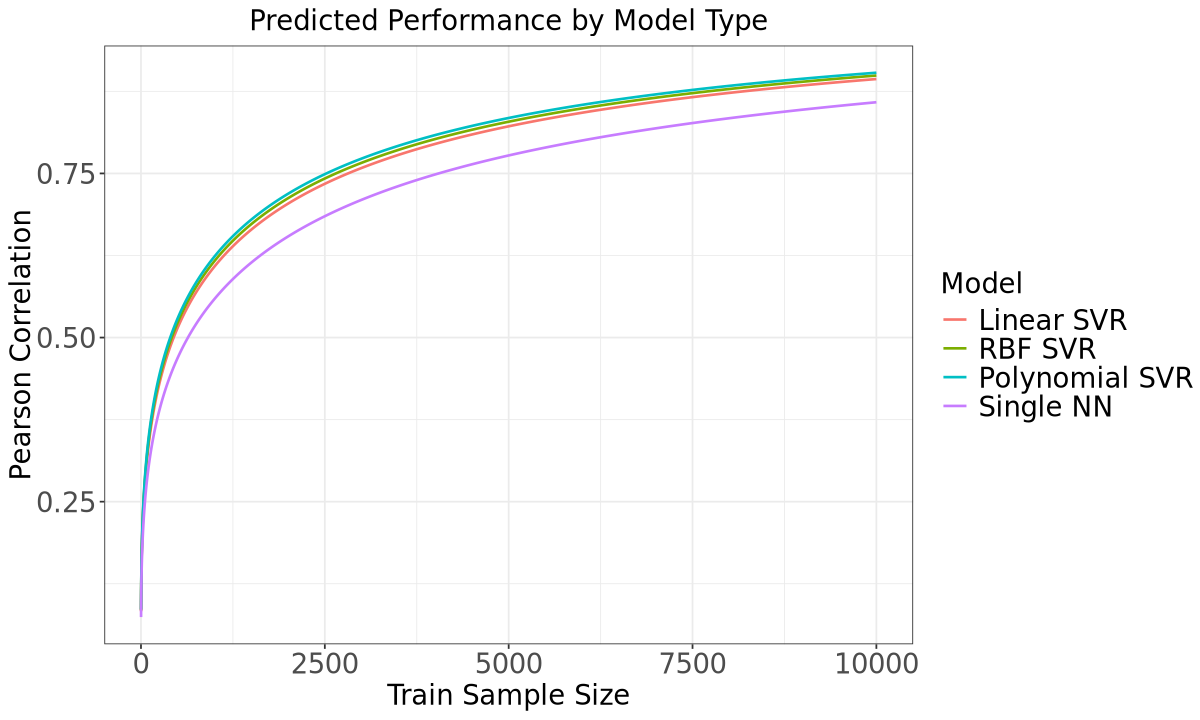

In [59]:
h = 6
w = 10

options(repr.plot.width = w, repr.plot.height = h)
g2_main

ggsave(filename = file.path(data_path, "figures", "power_analysis_predictino_pearson.png"), 
       plot = g2_main, dpi = 300, width = w, height = h)


In [60]:
file.path(data_path, "figures", "power_analysis_predictino_pearson.png")

[1] "/nobackup/users/hmbaghda/metastatic_potential//figures/power_analysis_predictino_pearson.png"

In [158]:
pf = summary(multi_R2_model)$coefficients
pf

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-1.079937117,0.007189261,-150.215324,0.000000e+00
log10_train_sample_size,0.309618522,0.003083468,100.412435,0.000000e+00
modelsvr_rbf,0.008137247,0.002554753,3.185140,1.448075e-03
modelsvr_poly,0.014842549,0.002554611,5.810102,6.296164e-09
modelANN,-0.048791396,0.002557902,-19.074770,1.028451e-80


In [159]:
summary(multi_mse_model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.602256448,0.003518855,171.151234,0.000000e+00
log10_train_sample_size,-0.112533775,0.001510001,-74.525637,0.000000e+00
modelsvr_rbf,-0.004576820,0.001260076,-3.632177,2.814303e-04
modelsvr_poly,-0.003490003,0.001260076,-2.769676,5.614082e-03
modelANN,0.047045866,0.001260076,37.335723,2.248427e-299


Max p-value:

In [162]:
max(rbind(pf, summary(multi_mse_model)$coefficients)[, 4])

[1] 0.005614082

Let's see how these translate to the original power function. We expect that, at a given sample size, the nonlinear model will perform 10^model_estimate better than the linear model for fisherZ_test_corr. 

For the rbf, this should be:

In [91]:
10^pf['modelsvr_rbf', 'Estimate']

[1] 1.018913

For svr, this should be: 

In [92]:
10^pf['modelsvr_poly', 'Estimate']

[1] 1.034767

For NNs:

In [93]:
10^pf['modelANN', 'Estimate']

[1] 0.8937347

In [94]:
fz_pd_c = dcast(predicted.data.corr, train_sample_size ~ model, value.var = 'fisherZ_test_corr')
head(fz_pd_c)

,train_sample_size,Linear SVR,RBF SVR,Polynomial SVR,Single NN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.08318842,0.08476179,0.08608063,0.07434838
2,2,0.10310206,0.10505206,0.10668660,0.09214589
3,3,0.11689299,0.11910382,0.12095700,0.10447132
4,4,0.12778263,0.13019942,0.13222524,0.11420376
5,5,0.13692317,0.13951284,0.14168357,0.12237298
6,6,0.14487482,0.14761489,0.14991168,0.12947965


In [95]:
head(fz_pd_c[['RBF SVR']]/fz_pd_c[['Linear SVR']])

[1] 1.018913 1.018913 1.018913 1.018913 1.018913 1.018913

In [96]:
head(fz_pd_c[['Polynomial SVR']]/fz_pd_c[['Linear SVR']])

[1] 1.034767 1.034767 1.034767 1.034767 1.034767 1.034767

In [97]:
head(fz_pd_c[['Single NN']]/fz_pd_c[['Linear SVR']])

[1] 0.8937347 0.8937347 0.8937347 0.8937347 0.8937347 0.8937347

In terms of the actual Pearson correlation, this means:

In [98]:
r_pd_c = dcast(predicted.data.corr, train_sample_size ~ model, value.var = 'test_corr')
r_pd_c$RBF.norm<-r_pd_c[['RBF SVR']]/r_pd_c[['Linear SVR']]
r_pd_c$Polynomial.norm<-r_pd_c[['Polynomial SVR']]/r_pd_c[['Linear SVR']]
r_pd_c$ANN.norm<-r_pd_c[['Single NN']]/r_pd_c[['Linear SVR']]

In [99]:
mean(r_pd_c$RBF.norm)

[1] 1.009343

In [100]:
mean(r_pd_c$Polynomial.norm)

[1] 1.01696

In [101]:
mean(r_pd_c$ANN.norm)

[1] 0.9419654

In [142]:
predicted.data.corr[predicted.data.corr$train_sample_size == 10000, ]

,train_sample_size,log10_train_sample_size,log10_fisherZ_test_corr,fisherZ_test_corr,test_corr,model
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
10000,10000,4,0.1585370,1.440579,0.8938141,Linear SVR
20000,10000,4,0.1733795,1.490663,0.9034467,Polynomial SVR
30000,10000,4,0.1666742,1.467825,0.8991617,RBF SVR
40000,10000,4,0.1097456,1.287495,0.8584691,Single NN


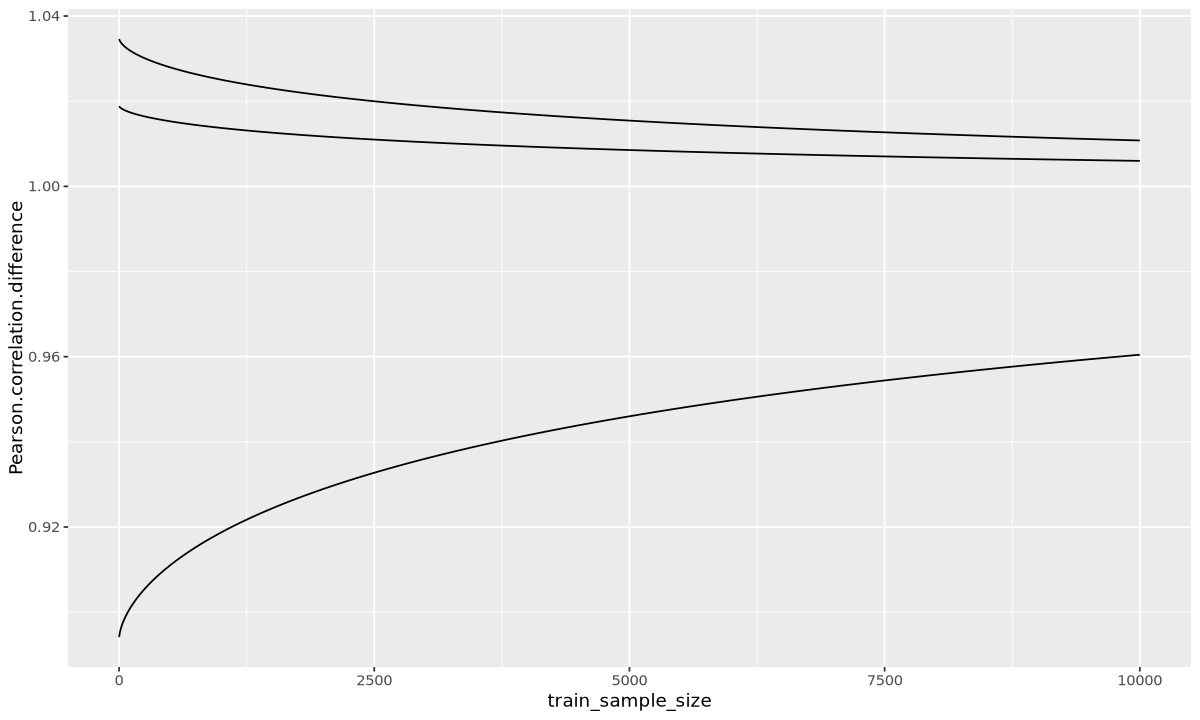

In [103]:
viz.df<-melt(r_pd_c %>% select(train_sample_size, RBF.norm, Polynomial.norm, ANN.norm), 
             id.vars = c('train_sample_size'), variable.name='model.type', 
            value.name='Pearson.correlation.difference')

ggplot(data = viz.df, 
       aes(x = train_sample_size, y = Pearson.correlation.difference, group = model.type)) + 
  geom_line()

In [107]:
figs = c(file.path(data_path, "figures", "power_analysis_barplots.png"),
file.path(data_path, "figures", "power_analysis_model_fits_all.png"),
file.path(data_path, "figures", "power_analysis_predictino_pearson.png"))

for (fig in figs){
    cmd = paste0('scp hmbaghda@satori-login-002.mit.edu:', fig, ' Downloads/mp_materials/mp_figures/.')
    print(cmd)
}

[1] "scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential//figures/power_analysis_barplots.png Downloads/mp_materials/mp_figures/."
[1] "scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential//figures/power_analysis_model_fits_all.png Downloads/mp_materials/mp_figures/."
[1] "scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential//figures/power_analysis_predictino_pearson.png Downloads/mp_materials/mp_figures/."
